1. Create a dataset of cumulative questions per library over time

In [ ]:
filename_zip_stackoverflow="/content/gdrive/MyDrive/data/data/stackoverflow.zip"

In [ ]:
import pandas as pd

questions_per_library=pd.read_csv(filename_zip_stackoverflow,parse_dates=True,index_col="creation_date")

In [ ]:
questions_per_library=questions_per_library.loc[:,"pandas":'bokeh'].resample('1M').sum().cumsum().reindex(
    pd.date_range('2008-08','2021-10',freq='M')
).fillna(0)

In [ ]:
questions_per_library.tail()

,pandas,matplotlib,numpy,seaborn,geopandas,geoviews,altair,yellowbrick,vega,holoviews,hvplot,bokeh
2021-05-31,200734.0,57853.0,89812.0,6855.0,1456.0,57.0,716.0,46.0,532.0,513.0,84.0,4270.0
2021-06-30,205065.0,58602.0,91026.0,7021.0,1522.0,57.0,760.0,48.0,557.0,521.0,88.0,4308.0
2021-07-31,209235.0,59428.0,92254.0,7174.0,1579.0,62.0,781.0,50.0,572.0,528.0,89.0,4341.0
2021-08-31,213410.0,60250.0,93349.0,7344.0,1631.0,62.0,797.0,52.0,589.0,541.0,92.0,4372.0
2021-09-30,214919.0,60554.0,93797.0,7414.0,1652.0,63.0,804.0,54.0,598.0,542.0,92.0,4386.0


2. Import the FuncAnimation class

In [ ]:
from matplotlib.animation import FuncAnimation

3. Write a function for generating the initial plot

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import ticker

def bar_plot(data):
  fig, ax = plt.subplots(figsize=(8, 6))
  sort_order = data.last('1M').squeeze().sort_values().index
  bars = [
      bar.set_label(label) for label, bar in
      zip(sort_order, ax.barh(sort_order, [0] * data.shape[1]))
  ]

  ax.set_xlabel('total questions', fontweight='bold')
  ax.set_xlim(0, 250_000)
  ax.xaxis.set_major_formatter(ticker.EngFormatter())
  ax.xaxis.set_tick_params(labelsize=12)
  ax.xaxis.set_tick_params(labelsize=12)

  for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

  fig.tight_layout()

  return fig, ax

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='total questions'>)

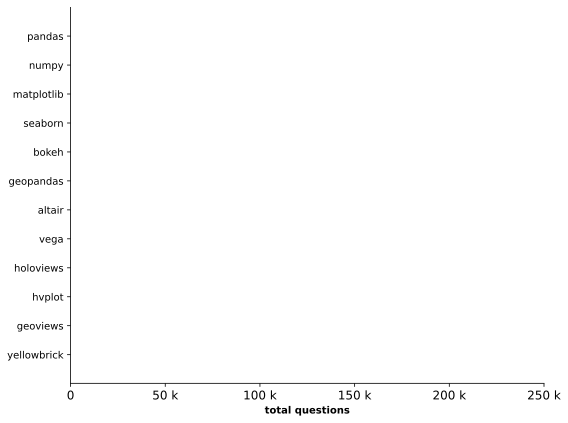

In [ ]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
bar_plot(questions_per_library)

4. Write a function for generating annotations and plot text

In [ ]:
def generate_plot_text(ax):
  annotations = [
      ax.annotate(
          '', xy=(0, bar.get_y() + bar.get_height()/2),
          ha='left', va='center'
      ) for bar in ax.patches
  ]

  time_text = ax.text(
      0.9, 0.1, '', transform = ax.transAxes,
      fontsize=15, ha='center', va='center'
  )
  return annotations, time_text

5. Define the plot update function

In [ ]:
def update(frame, *, ax, df, annotations, time_text):
  data = df.loc[frame, :]

  #update bars
  for rect, text in zip (ax.patches, annotations):
    col = rect.get_label()
    if data[col]:
      rect.set_width(data[col])
      text.set_x(data[col])
      text.set_text(f' {data[col]:,.0f}')

      #update time
      time_text.set_text(frame.strftime('%b\n%Y'))

6. Bind arguments to the update function

In [ ]:
from functools import partial

def bar_plot_init(questions_per_library):
  fig, ax = bar_plot(questions_per_library)
  annotations, time_text = generate_plot_text(ax)

  bar_plot_update = partial(
      update, ax=ax, df=questions_per_library,
      annotations=annotations, time_text=time_text
  )

  return fig, bar_plot_update

7. Animate the plot

In [ ]:
fig, update_func = bar_plot_init(questions_per_library)

ani = FuncAnimation(
    fig, update_func, frames=questions_per_library.index, repeat=False
)
ani.save(
    '../media/stackoverflow_questions.mp4',
    writer='ffmpeg', fps=10, bitrate=100, dpi=300
)
plt.close()

In [ ]:
from IPython import display

display.Video(
    '../media/stackoverflow_questions.mp4', width=600, height=400, embed=True, html_attributes='controls muted autoplay'
)

- Animating distribution over time

1. Create a dataset of daily subway entries

In [ ]:
subway_file="/content/gdrive/MyDrive/data/data/NYC_subway_daily.csv"

In [ ]:
subway = pd.read_csv(
    subway_file, parse_dates=['Datetime'],
    index_col=['Borough', 'Datetime']
)
subway_daily = subway.unstack(0)
subway_daily.head()

Entries                                    Exits            \
Borough            Bk        Bx          M         Q        Bk        Bx   
Datetime                                                                   
2017-02-04   617650.0  247539.0  1390496.0  408736.0  417449.0  148237.0   
2017-02-05   542667.0  199078.0  1232537.0  339716.0  405607.0  139856.0   
2017-02-06  1184916.0  472846.0  2774016.0  787206.0  761166.0  267991.0   
2017-02-07  1192638.0  470573.0  2892462.0  790557.0  763653.0  270007.0   
2017-02-08  1243658.0  497412.0  2998897.0  825679.0  788356.0  275695.0   

                                 
Borough             M         Q  
Datetime                         
2017-02-04  1225689.0  279699.0  
2017-02-05  1033610.0  268626.0  
2017-02-06  2240027.0  537780.0  
2017-02-07  2325024.0  544828.0  
2017-02-08  2389534.0  559639.0

In [ ]:
manhattan_entries = subway_daily['Entries']['M']

2. Determine the bin ranges for the histograms

In [ ]:
import numpy as np

counter_per_bin, bin_ranges = np.histogram(manhattan_entries, bins=30)

3. Write a function for generating the initial histogram subplots

In [ ]:
def subway_histogram(data, bins, date_range):
  _, bin_ranges = np.histogram(data, bins=bins)
  
  weekday_mask = data.index.weekday < 5
  configs = [
      {'label': 'Weekend', 'mask': ~weekday_mask, 'ymax': 60},
      {'label': 'Weekday', 'mask': weekday_mask, 'ymax': 120}
  ]

  fig, axes = plt.subplots(1,2,figsize=(8,4), sharex=True)
  for ax, config in zip(axes, configs):
    _, _, config['hist'] = ax.hist(
        data[config['mask']].loc[date_range], bin_ranges, ec='black'
    )
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.set(
        xlim=(0,None), ylim = (0, config['ymax']),
        xlabel=f'{config["label"]} Entries'
    )
    for spine in ['top', 'right']:
      ax.spines[spine].set_visible(False)
  
  axes[0].set_ylabel('Frequency')
  fig.suptitle('Histogram of Daily Subway Entries in Manhattan')
  fig.tight_layout()

  return fig, axes, bin_ranges, configs


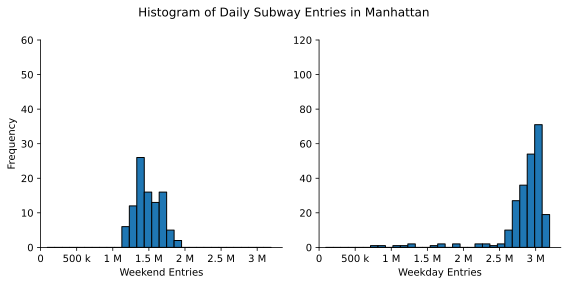

In [ ]:
_ = subway_histogram(manhattan_entries, bins=30, date_range='2017')

4. Write a function for generating an annotation for the time period

In [ ]:
def add_time_text(ax):
  time_text = ax.text(
      0.15, 0.9, '', transform = ax.transAxes,
      fontsize=15, ha='center', va='center'
  )
  return time_text

5. Define the plot update function

In [ ]:
from pandas.core import frame
def update(frame, *, data, configs, time_text, bin_ranges):
  artists = []

  time = frame.strftime('%b\n%Y')
  if time != time_text.get_text():
    time_text.set_text(time)
    artists.append(time_text)

  for config in configs:
    time_frame_mask = \
      (data.index > frame - pd.Timedelta(days = 365)) & (data.index <= frame)
    counts, _ = np.histogram(
        data[time_frame_mask & config['mask']],
        bin_ranges
    )
    for count, rect in zip(counts, config['hist'].patches):
      if count != rect.get_height():
        rect.set_height(count)
        artists.append(rect)

    return artists

6. Bind arguments for the update function

In [ ]:
def histogram_init(data, bins, initial_date_range):
  fig, axes, bin_ranges, configs = subway_histogram(data, bins, initial_date_range)

  update_func = partial(
      update, data=data, configs=configs,
      time_text=add_time_text(axes[0]),
      bin_ranges=bin_ranges
  )

  return fig, update_func

7. Animate the plot

In [ ]:
from sqlalchemy.sql.expression import true
fig, update_func = histogram_init(
    manhattan_entries, bins=30, initial_date_range=slice('2017','2019-07')
)

ani = FuncAnimation(
    fig, update_func, frames=manhattan_entries['2019-08':'2021'].index,
    repeat=False, blit=true
)

ani.save(
    '../media/subway_entries_subplots.mp4',
    writer='ffmpeg', fps=30, bitrate=500, dpi=300
)
plt.close()

In [ ]:
from IPython import display

display.Video(
    '../media/subway_entries_subplots.mp4', width=600, height=400, 
    embed=True, html_attributes='controls muted autoplay'
)

Additional plot types

In [43]:
market_file ="/content/gdrive/MyDrive/data/data/T100_MARKET_ALL_CARRIER.zip"

In [44]:
import numpy as np

flight_stats = pd.read_csv(
    market_file,
    usecols=[
        'CLASS', 'REGION','UNIQUE_CARRIER_NAME','ORIGIN_CITY_NAME','ORIGIN',
        'DEST_CITY_NAME','DEST','PASSENGERS','FREIGHT','MAIL'
    ]
).rename(lambda x: x.lower(), axis=1).assign(
    region=lambda x: x.region.replace({
        'D': 'Domestic', 'I': 'International', 'A': 'Atlantic',
        'L': 'Latin America', 'P': 'Pacific', 'S': 'System'
    }),
    route=lambda x: np.where(
        x.origin < x.dest,
        x.origin + '-' + x.dest,
        x.dest + '-' + x.origin
    )
)

In [54]:
flight_stats.head(20)

,passengers,freight,mail,unique_carrier_name,region,origin,origin_city_name,dest,dest_city_name,class,route
0,0.0,53185.0,0.0,Emirates,International,DXB,"Dubai, United Arab Emirates",IAH,"Houston, TX",G,DXB-IAH
1,0.0,9002.0,0.0,Emirates,International,DXB,"Dubai, United Arab Emirates",JFK,"New York, NY",G,DXB-JFK
2,0.0,2220750.0,0.0,Emirates,International,DXB,"Dubai, United Arab Emirates",ORD,"Chicago, IL",G,DXB-ORD
3,0.0,1201490.0,0.0,Emirates,International,IAH,"Houston, TX",DXB,"Dubai, United Arab Emirates",G,DXB-IAH
4,0.0,248642.0,0.0,Emirates,International,JFK,"New York, NY",DXB,"Dubai, United Arab Emirates",G,DXB-JFK
5,0.0,3437630.0,0.0,Emirates,International,ORD,"Chicago, IL",DXB,"Dubai, United Arab Emirates",G,DXB-ORD
6,0.0,1244.0,0.0,Bemidji Airlines,Domestic,BJI,"Bemidji, MN",BRD,"Brainerd, MN",F,BJI-BRD
7,0.0,9464.0,0.0,Bemidji Airlines,Domestic,BJI,"Bemidji, MN",MSP,"Minneapolis, MN",F,BJI-MSP
8,0.0,5550.0,0.0,Bemidji Airlines,Domestic,BRD,"Brainerd, MN",MSP,"Minneapolis, MN",F,BRD-MSP
9,0.0,20417.0,0.0,Bemidji Airlines,Domestic,MSP,"Minneapolis, MN",BJI,"Bemidji, MN",F,BJI-MSP


In [46]:
cities = [
    'Atlanta, GA', 'Chicago, IL', 'New York, NY', 'Los Angeles, CA',
    'Dallas/Fort Worth, TX', 'Denver, CO', 'Houston, TX', 
    'San Francisco, CA', 'Seattle, WA', 'Orlando, FL'
]

top_airlines = [
    'American Airlines Inc.', 'Delta Air Lines Inc.', 'JetBlue Airways',
    'Southwest Airlines Co.', 'United Air Lines Inc.'
]

Chord diagram

1. Aggragate the dataset to get total flight statistics between the top cities

In [47]:
total_flight_stats = flight_stats.query(
    f'`class`=="F" and origin_city_name != dest_city_name'
    f' and origin_city_name.isin({cities}) and dest_city_name.isin({cities})'
).groupby([
    'origin', 'origin_city_name', 'dest', 'dest_city_name'
])[['passengers', 'freight', 'mail']].sum().reset_index().query('passengers > 0')

In [48]:
total_flight_stats.sample(10, random_state=1)

,origin,origin_city_name,dest,dest_city_name,passengers,freight,mail
78,LGA,"New York, NY",DEN,"Denver, CO",589190.0,506023.0,293108.0
117,ORD,"Chicago, IL",SEA,"Seattle, WA",810594.0,1063463.0,2627325.0
31,DFW,"Dallas/Fort Worth, TX",MCO,"Orlando, FL",683700.0,187672.0,95570.0
5,ATL,"Atlanta, GA",LAX,"Los Angeles, CA",1121378.0,8707125.0,3267077.0
126,SEA,"Seattle, WA",LGA,"New York, NY",24.0,0.0,0.0
45,IAH,"Houston, TX",ATL,"Atlanta, GA",566369.0,367543.0,726670.0
14,DEN,"Denver, CO",HOU,"Houston, TX",305193.0,363119.0,0.0
44,HOU,"Houston, TX",SFO,"San Francisco, CA",1843.0,5523.0,0.0
73,LAX,"Los Angeles, CA",MDW,"Chicago, IL",277226.0,2022416.0,0.0
89,MCO,"Orlando, FL",DEN,"Denver, CO",594878.0,368516.0,138811.0


2. Create a chord diagram with HoloViews

In [49]:
chord = hv.Chord(
    total_flight_stats,
    kdims=['origin', 'dest'],
    vidms=['passengers', 'origin_city_name','dest_city_name', 'mail','freight']
)

3. Customize the tooltips using Bokeh

In [50]:
from bokeh.models import HoverTool

tooltips = {
    'Source': '@origin_city_name (@origin)',
    'Target': '@dest_city_name (@dest)',
    'Passengers': '@passengers{0,.}',
    'Mail': '@mail{0,.} lbs.',
    'Freight': '@freight{0,.} lbs.'
}
hover = HoverTool(tooltips=tooltips)

Sankey plot

1. Isolate flight statistics for top routes

In [55]:
top_cities = cities[:5]

domestic_passenger_travel = flight_stats.query(
    'region == "Domestic" and `class` == "F" and origin_city_name != dest_city_name '
    f'and origin_city_name.isin({top_cities}) and dest_city_name.isin({top_cities})' 
).groupby([
    'region', 'unique_carrier_name','route',
    'origin_city_name','dest_city_name'
]).passengers.sum().reset_index()

domestic_passenger_travel.head(10)

,region,unique_carrier_name,route,origin_city_name,dest_city_name,passengers
0,Domestic,Air Wisconsin Airlines Corp,ATL-ORD,"Atlanta, GA","Chicago, IL",915.0
1,Domestic,Air Wisconsin Airlines Corp,ATL-ORD,"Chicago, IL","Atlanta, GA",556.0
2,Domestic,Alaska Airlines Inc.,JFK-LAX,"Los Angeles, CA","New York, NY",265307.0
3,Domestic,Alaska Airlines Inc.,JFK-LAX,"New York, NY","Los Angeles, CA",257685.0
4,Domestic,Alaska Airlines Inc.,LAX-ORD,"Chicago, IL","Los Angeles, CA",48269.0
5,Domestic,Alaska Airlines Inc.,LAX-ORD,"Los Angeles, CA","Chicago, IL",48482.0
6,Domestic,American Airlines Inc.,ATL-DFW,"Atlanta, GA","Dallas/Fort Worth, TX",363943.0
7,Domestic,American Airlines Inc.,ATL-DFW,"Dallas/Fort Worth, TX","Atlanta, GA",359152.0
8,Domestic,American Airlines Inc.,ATL-JFK,"Atlanta, GA","New York, NY",369.0
9,Domestic,American Airlines Inc.,ATL-JFK,"New York, NY","Atlanta, GA",319.0


2. Convert the data into a set of edges

In [57]:
domestic_passenger_travel.unique_carrier_name.replace(
    '^(?!' + '|'.join(top_airlines) + ').*$',
    'Other Airline',
    regex=True, inplace=True
)

In [59]:
domestic_passenger_travel.groupby('unique_carrier_name').passengers.sum().div(
    domestic_passenger_travel.passengers.sum()
)

unique_carrier_name
American Airlines Inc.    0.337186
Delta Air Lines Inc.      0.312187
JetBlue Airways           0.049500
Other Airline             0.120544
Southwest Airlines Co.    0.079074
United Air Lines Inc.     0.101509
Name: passengers, dtype: float64

In [60]:
def get_edges(data, *, source_col, target_col):
  aggregated = data.groupby([source_col, target_col]).passengers.sum()
  return aggregated.reset_index().rename(
      columns={source_col: 'source', target_col: 'target'}
  ).query('passengers > 0')

In [62]:
carrier_edges = get_edges(
    domestic_passenger_travel,
    source_col='region',
    target_col='unique_carrier_name'
).replace('Domestic', 'Top Routes')

carrier_edges

,source,target,passengers
0,Top Routes,American Airlines Inc.,9426060.0
1,Top Routes,Delta Air Lines Inc.,8727210.0
2,Top Routes,JetBlue Airways,1383776.0
3,Top Routes,Other Airline,3369815.0
4,Top Routes,Southwest Airlines Co.,2210533.0
5,Top Routes,United Air Lines Inc.,2837682.0


In [63]:
carrier_to_route_edges = get_edges(
    domestic_passenger_travel,
    source_col='unique_carrier_name',
    target_col='route'
)

carrier_to_route_edges.sample(10, random_state=1)

,source,target,passengers
39,Other Airline,DFW-LGA,157366.0
41,Other Airline,JFK-LAX,523222.0
2,American Airlines Inc.,ATL-LAX,294304.0
48,Southwest Airlines Co.,ATL-MDW,498481.0
50,Southwest Airlines Co.,LAX-MDW,558574.0
44,Other Airline,LAX-ORD,378552.0
33,Other Airline,ATL-LAX,146882.0
35,Other Airline,ATL-MDW,1201.0
40,Other Airline,DFW-ORD,241147.0
27,JetBlue Airways,DFW-JFK,140.0


In [64]:
all_edges = pd.concat([carrier_edges, carrier_to_route_edges]).assign(
    passengers=lambda x: x.passengers / 1e6
)

4. Create the Sankey plot with HoloViews

In [65]:
sankey = hv.Sankey(
    all_edges,
    kdims = ['source', 'target'],
    vdims = hv.Dimension('passengers', unit='M')
).opts(
    labels='index', label_position='right', cmap='Set1', #node config
    edge_color = 'lightgray', #edge config
    width=750, height=600, #plot size config
    title='Travel Between the Top 5 cities in 2019'
)

:Sankey   [source,target]   (passengers)
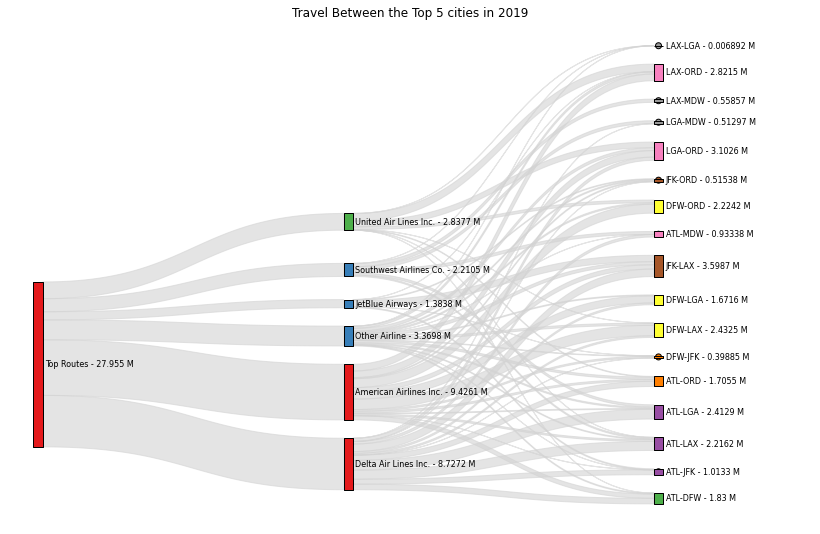

In [66]:
sankey